# Data Pre-Processing MFCC

* This notebook will provide the code for the data pre-processing of the Mel-Frequency Cepstral Coeffi

In [4]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

from scipy.io import wavfile
from scipy import signal
from scipy.fftpack import dct

In [5]:
#change the directory
os.chdir("C:\\Users\\b9027741\\OneDrive - Newcastle University\\Masters\\Computer Science\\Machine_Learning_Project\\Data")

In [6]:
#labels needed - using the 6 I have specified
labels = ["yes", "no", "up", "down", "left", "right"]

In [60]:
def mfcc_filter_banks_transformation(wavname,directory,pre_emphasis=0.97,frame_size=0.025,frame_stride=0.01,
                       NFFT = 512,nfilt=40,num_ceps=12,cep_lifter=23):
    
    #this function will transform a wavfile into the mfcc
    
    #read in the specified wavfile
    sample_rate, sample = wavfile.read(directory+wavname)
    
    #pad the sample length
    if (len(sample) < 16000):
        sample = np.pad(sample, (0, (16000 - len(sample))), "linear_ramp")
    
    #apply a pre-emphasis filter to the samples
    emphasized_signal = np.append(sample[0], sample[1:] - pre_emphasis * sample[:-1])
    
    #split the signal into short time frames
    frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate 
    signal_length = len(emphasized_signal)
    frame_length = int(round(frame_length))
    frame_step = int(round(frame_step))
    num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step)) 

    pad_signal_length = num_frames * frame_step + frame_length
    z = np.zeros((pad_signal_length - signal_length))
    pad_signal = np.append(emphasized_signal, z) 

    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    frames = pad_signal[indices.astype(np.int32, copy=False)]
    
    #hamming window is then applided to the function
    frames *= np.hamming(frame_length)
    
    #calculate the frequency spectrum with a STFT
    
    #mag_frames - magnitude of the FFT
    mag_frames = np.absolute(np.fft.rfft(frames,NFFT))
    #pow_frames - power spectrum
    pow_frames = ((1/NFFT)*((mag_frames)**2))
    
    #compute the filter banks
    low_freq_mel = 0
    high_freq_mel = (2595*np.log10(1+(sample_rate/2)/700))
    mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt+2)
    hz_points = (700 * (10**(mel_points / 2595) - 1))
    bin = np.floor((NFFT + 1) * hz_points / sample_rate)
    
    fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
    
    for m in range(1, nfilt + 1):
        f_m_minus = int(bin[m-1])
        f_m = int(bin[m])
        f_m_plus = int(bin[m+1])
        
        for k in range(f_m_minus,f_m):
            fbank[m-1,k] = (k-bin[m-1]) / (bin[m] - bin[m-1])
        for k in range(f_m,f_m_plus):
            fbank[m-1,k] = (bin[m+1] - k) / (bin[m+1] - bin[m])
    
    filter_banks = np.dot(pow_frames, fbank.T)
    filter_banks = np.where(filter_banks==0,np.finfo(float).eps, filter_banks)
    filter_banks = 20 * np.log10(filter_banks)
    
    #apply discrete cosine transform
    mfcc = dct(filter_banks, type=2, axis=1, norm="ortho")[:,1:(num_ceps+1)]
    
    #apply sinusoidal liftering
    (nframes, ncoeff) = mfcc.shape
    n = np.arange(ncoeff)
    lift = 1 + (cep_lifter/2) * np.sin(np.pi * n / cep_lifter)
    mfcc *= lift
    
    #mean normalization
    filter_banks -= (np.mean(filter_banks,axis=0)+1e-8)
    mfcc -= (np.mean(mfcc,axis=0)+1e-8)
    
    return mfcc, filter_banks
       

(98, 12)
(98, 40)


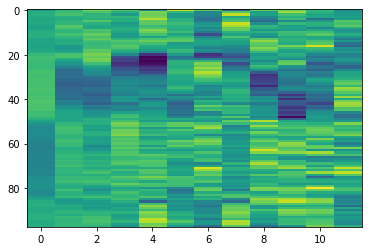

In [62]:
mfcc, filter_banks = mfcc_filter_banks_transformation("yes/00f0204f_nohash_0.wav","train/audio/")

plt.imshow(mfcc,aspect="auto")

print(mfcc.shape)
print(filter_banks.shape)

In [63]:
all_files = pd.DataFrame(columns=("file_name","label"))
all_files = all_files.fillna(0)

for label in labels:
    files = os.listdir("train/audio/" + label)
    for file in files:
        all_files = all_files.append({
                    "file_name":file,
                    "label":label
                    },ignore_index=True)

print(all_files.head())

               file_name label
0  004ae714_nohash_0.wav   yes
1  004ae714_nohash_1.wav   yes
2  00f0204f_nohash_0.wav   yes
3  00f0204f_nohash_1.wav   yes
4  00f0204f_nohash_2.wav   yes


In [64]:
print(all_files["label"].value_counts())
print(all_files.shape)

yes      2377
no       2375
up       2375
right    2367
down     2359
left     2353
Name: label, dtype: int64
(14206, 2)


In [65]:
#train / test split

training_files = all_files.sample(frac=0.9,random_state=42)
test_files = all_files.drop(training_files.index)

print(training_files.head())
print(test_files.head())

print("training_files shape: " + str(training_files.shape))
print("test_files shape: " + str(test_files.shape))

                   file_name  label
8572   a42a88ff_nohash_0.wav   down
4098   bd8412df_nohash_1.wav     no
14004  eb0676ec_nohash_0.wav  right
7562   33f60c62_nohash_0.wav   down
12213  2f813234_nohash_1.wav  right
                file_name label
4   00f0204f_nohash_2.wav   yes
5   012c8314_nohash_0.wav   yes
9   0132a06d_nohash_3.wav   yes
55  05b2db80_nohash_2.wav   yes
64  06a79a03_nohash_0.wav   yes
training_files shape: (12785, 2)
test_files shape: (1421, 2)


In [66]:
#train / validation split

train_files = training_files.sample(frac=0.8,random_state=42)
validation_files = training_files.drop(train_files.index)

print(train_files.head())
print(validation_files.head())
print(test_files.head())

print("training_files shape: " + str(train_files.shape))
print("validation_files shape: " + str(validation_files.shape))

#we now have the train/validation and test split needed
#train_files
#validation_files
#test_files

                   file_name label
3438   78884794_nohash_2.wav    no
10731  8c7c9168_nohash_2.wav  left
9682   19f9c115_nohash_0.wav  left
321    24befdb3_nohash_2.wav   yes
6140   9886d8bf_nohash_4.wav    up
                   file_name  label
4098   bd8412df_nohash_1.wav     no
12213  2f813234_nohash_1.wav  right
3233   64da5281_nohash_2.wav     no
8757   b83c1acf_nohash_3.wav   down
7495   2bfe70ef_nohash_0.wav   down
                file_name label
4   00f0204f_nohash_2.wav   yes
5   012c8314_nohash_0.wav   yes
9   0132a06d_nohash_3.wav   yes
55  05b2db80_nohash_2.wav   yes
64  06a79a03_nohash_0.wav   yes
training_files shape: (10228, 2)
validation_files shape: (2557, 2)


In [67]:
def create_mfcc_data(files,directory="train/audio/"):
    X = np.zeros([files.shape[0],98,12])
    Y = np.zeros([files.shape[0]])
    index = 0
    for ind, row in files.iterrows():
        try:
            mfcc, filter_banks = mfcc_filter_banks_transformation(wavname=(row["label"]+"/"+row["file_name"]),directory=directory)
            X[index] = mfcc
        except ValueError:
            print(row,ValueError)
        Y[index] = labels.index(row["label"])
        index += 1
        
    return X, Y
    
X_train, Y_train = create_mfcc_data(train_files)
X_val, Y_val = create_mfcc_data(validation_files)
X_test, Y_test = create_mfcc_data(test_files)

Text(0.5, 1.0, '3.0')

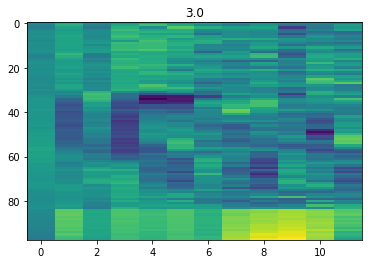

In [69]:
plt.imshow(X_train[435],aspect="auto")
plt.title(Y_train[435])

In [74]:
#check the shapes of the data
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(10228, 98, 12)
(2557, 98, 12)
(1421, 98, 12)


In [75]:
#save the mfcc data ready for the analysis
np.save("train/data/mfcc/X_train_mfcc", np.expand_dims(X_train,-1)+1.3)
np.save("train/data/mfcc/Y_train_mfcc",Y_train.astype(np.int))
np.save("train/data/mfcc/X_val_mfcc",np.expand_dims(X_val,-1)+1.3)
np.save("train/data/mfcc/Y_val_mfcc",Y_val.astype(np.int))
np.save("train/data/mfcc/X_test_mfcc",np.expand_dims(X_test,-1)+1.3)
np.save("train/data/mfcc/Y_test_mfcc",Y_test.astype(np.int))

In [ ]:
def create_filter_bank_data(files,directory="train/audio/"):
    X = np.zeros([files.shape[0],98,40])
    Y = np.zeros([files.shape[0]])
    index = 0
    for ind, row in files.iterrows():
        try:
            mfcc, filter_banks = mfcc_filter_banks_transformation(wavname=(row["label"]+"/"+row["file_name"]),directory=directory)
            X[index] = filter_banks
        except ValueError:
            print(row,ValueError)
        Y[index] = labels.index(row["label"])
        index += 1
        
    return X, Y
    
X_train, Y_train = create_mfcc_data(train_files)
X_val, Y_val = create_mfcc_data(validation_files)
X_test, Y_test = create_mfcc_data(test_files)

In [ ]:
#save the mfcc data ready for the analysis
np.save("train/data/mfcc/X_train_fb", np.expand_dims(X_train,-1)+1.3)
np.save("train/data/mfcc/Y_train_fb",Y_train.astype(np.int))
np.save("train/data/mfcc/X_val_fb",np.expand_dims(X_val,-1)+1.3)
np.save("train/data/mfcc/Y_val_f",Y_val.astype(np.int))
np.save("train/data/mfcc/X_test_mfcc",np.expand_dims(X_test,-1)+1.3)
np.save("train/data/mfcc/Y_test_mfcc",Y_test.astype(np.int))